In [92]:
import yfinance as yf
import tensorflow as tf
import numpy as np
import pandas as pd
import requests
from transformers import pipeline
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Flatten, Concatenate, concatenate
import matplotlib.pyplot as plt
from finbert_utils import estimate_sentiment
from datetime import datetime 
from alpaca_trade_api import REST 
from dotenv import load_dotenv

In [ ]:
API_KEY = "PKRIOHM2XO72IUBWVFSW" 
API_SECRET = "6SBDLMa5Os9cG1KCHYqgMNwdrwYanmnJNQI4Yoxo" 
BASE_URL = "https://paper-api.alpaca.markets"

ALPACA_CREDS = {
    "API_KEY":API_KEY, 
    "API_SECRET": API_SECRET, 
    "PAPER": True
}

api = REST(base_url=BASE_URL, key_id=API_KEY, secret_key=API_SECRET)

In [93]:
TOP_25_STOCKS = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 
                 'TSLA', 'GOOG', 'BRK-B', 'META', 'UNH', 
                 'XOM', 'LLY', 'JPM', 'JNJ', 'V', 
                 'PG', 'MA', 'AVGO', 'HD', 'CVX', 
                 'MRK', 'ABBV', 'COST', 'PEP', 'ADBE']
#(last50days, last200days, last50vols, ticker)
#Encoding tickers
label_encoder = LabelEncoder()
TICKERS_ENCODED = label_encoder.fit_transform(TOP_25_STOCKS)
TICKERS_ONEHOT = to_categorical(TICKERS_ENCODED)

In [ ]:
def get_sentiment(api, start_date, end_date,stock): 
        news = api.get_news(symbol=stock, 
                                 start=start_date, 
                                 end=end_date) 
        news = [ev.__dict__["_raw"]["headline"] for ev in news]
        print(news)
        probability, sentiment = estimate_sentiment(news)
        return probability, sentiment 

In [1]:
#downloading stock data

directory = 'TrainStockData'

for stock in TOP_25_STOCKS:
    data = yf.download(stock, start="2011-01-01", end="2022-03-01")
    data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close'])
    data.insert(0, 'Ticker', stock, True)
    sentiments = []
    data['Date'] = data.index
    data['index'] = range(len(data))
    data.set_index('index', inplace=True)

    sentiment_data = []
    for i in range(len(data)):
        start_date = data['Date'].values[i]
        if i == len(data)-1:
            end_date = '2022-03-02'
        else:
            end_date = data['Date'].values[i+1]
        probability, sentiment = get_sentiment(api, start_date, end_date, )
        

    # for date in data.index:
    #     year = int(date.split('-')[0])
    #     month = int(date.split('-')[1])
    #     day = int(date.split('-')[2])
    
    #     sumSentiments = 0
    #     numSentiments = 0
    #     print(date)
        
    #     avgSentiments = None
    #     if numSentiments != 0:
    #         avgSentiments = sumSentiments/numSentiments
        
    data.to_csv(os.path.join(directory, f'Train_{stock}.csv'))

NameError: name 'TOP_25_STOCKS' is not defined

In [95]:
# Function to load data
def load_data(directory, stocks):
    all_data = []
    for stock in stocks:
        file_path = os.path.join(directory, f'Train_{stock}.csv')
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
            all_data.append(data)
    return pd.concat(all_data)

In [96]:
# Define input layers
price_input = Input(shape=(50, 1), name='price_input')
indicator_input = Input(shape=(200, 1), name='indicator_input')
volume_input = Input(shape=(50, 1), name='volume_input')
ticker_input = Input(shape=(25,), name='ticker_input')  # One-hot encoded ticker

# LSTM layers for sequential data
price_lstm = LSTM(128, return_sequences=False)(price_input)
indicator_lstm = LSTM(128, return_sequences=False)(indicator_input)
volume_lstm = LSTM(128, return_sequences=False)(volume_input)

# Concatenate LSTM outputs with the ticker input
merged = concatenate([price_lstm, indicator_lstm, volume_lstm, ticker_input])

# Dense layers to produce the output
dense1 = Dense(64, activation='relu')(merged)
output = Dense(3, activation='linear', name='output')(dense1)  # Output shape (num, num, num)

# Define the model
model = Model(inputs=[price_input, indicator_input, volume_input, ticker_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_input         │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ indicator_input     │ (None, 200, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ volume_input        │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 128)       │     66,560 │ price_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 128)       │     66,560 │ indicator_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 128)       │     66,560 │ volume_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ticker_input        │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 409)       │          0 │ lstm_6[0][0],     │
│ (Concatenate)       │                   │            │ lstm_7[0][0],     │
│                     │                   │            │ lstm_8[0][0],     │
│                     │                   │            │ ticker_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     26,240 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3)         │        195 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 226,115 (883.26 KB)

 Trainable params: 226,115 (883.26 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
def preprocess_data(directory, stocks, time_steps=50):
    X_50 = []
    X_200 = []
    X_vol = []
    X_ticker = []

    y = []

    for stock in stocks:
        file_path = os.path.join(directory, f'Train_{stock}.csv')
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
        
        for i in range(time_steps*4, len(data) - 7):
            X_50.append(data['Close'].values[i-time_steps:i])
            X_200.append(data['Close'].values[i-time_steps*4:i])
            X_vol.append(data['Volume'].values[i-time_steps:i])
            
            label_encoder = LabelEncoder()
            TICKERS_ENCODED = label_encoder.fit_transform(stocks)
            TICKERS_ONEHOT = to_categorical(TICKERS_ENCODED)
            ticker_onehot = TICKERS_ONEHOT[stocks.index(stock)]
            X_ticker.append(ticker_onehot)

            next_day = data['Close'].values[i]
            three_days = data['Close'].values[i+3]
            next_week = data['Close'].values[i+7]

            y.append(np.array([next_day, three_days, next_week]))

    return (np.array(X_50), np.array(X_200), np.array(X_vol), np.array(X_ticker)), np.array(y)



In [98]:
(X_50, X_200, X_vol, X_ticker), y = preprocess_data('TrainStockData', TOP_25_STOCKS)
print(y)

[[ 15.07999992  14.03107071  14.45321369]
 [ 14.23642921  14.491786    14.46249962]
 [ 14.11821365  14.2060709   14.45642853]
 ...
 [474.01000977 457.70999146 463.82000732]
 [479.5        442.55999756 465.54000854]
 [477.70001221 438.3999939  467.67999268]]


In [99]:
X = [X_50, X_200, X_vol, X_ticker]

# Split into training and testing sets first
X_50_train, X_50_test, X_200_train, X_200_test, X_vol_train, X_vol_test, X_ticker_train, X_ticker_test, y_train, y_test = train_test_split(
    X_50, X_200, X_vol, X_ticker, y, test_size=0.2, random_state=42)

# Split the training set further into training and validation sets
X_50_train, X_50_val, X_200_train, X_200_val, X_vol_train, X_vol_val, X_ticker_train, X_ticker_val, y_train, y_val = train_test_split(
    X_50_train, X_200_train, X_vol_train, X_ticker_train, y_train, test_size=0.2, random_state=42)


# Verify the split
print(f"Train set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")

Train set size: 41072
Test set size: 12836


In [100]:
# Train the model with validation data
model.fit(
    [X_50_train, X_200_train, X_vol_train, X_ticker_train], 
    y_train, 
    epochs=5, 
    batch_size=32, 
    validation_data=([X_50_val, X_200_val, X_vol_val, X_ticker_val], y_val),
)

Epoch 1/5
1284/1284 ━━━━━━━━━━━━━━━━━━━━ 156s 120ms/step - accuracy: 0.3616 - loss: 3766.7405 - val_accuracy: 0.4352 - val_loss: 64.8985
Epoch 2/5
1284/1284 ━━━━━━━━━━━━━━━━━━━━ 138s 107ms/step - accuracy: 0.4024 - loss: 45.0469 - val_accuracy: 0.4471 - val_loss: 44.5690
Epoch 3/5
1284/1284 ━━━━━━━━━━━━━━━━━━━━ 147s 114ms/step - accuracy: 0.3902 - loss: 38.9559 - val_accuracy: 0.4114 - val_loss: 27.4215
Epoch 4/5
1284/1284 ━━━━━━━━━━━━━━━━━━━━ 140s 109ms/step - accuracy: 0.3911 - loss: 35.9513 - val_accuracy: 0.4168 - val_loss: 29.1037
Epoch 5/5
1284/1284 ━━━━━━━━━━━━━━━━━━━━ 149s 116ms/step - accuracy: 0.3872 - loss: 32.2759 - val_accuracy: 0.2982 - val_loss: 28.3879


In [101]:
#model = tf.keras.models.load_model('models.keras')

In [102]:
data = yf.download('ADBE', start="2022-03-01", end="2024-01-01")
data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close'])
data.insert(0, 'Ticker', stock, True)

data['Date'] = data.index
data['index'] = range(len(data))
data.set_index('index', inplace=True)

dates = []
x50 = []
x200 = []
xvol = []
xticker = []

yvals = []

for i in range(50*4, len(data) - 7):
    dates.append(data['Date'].values[i-1])
    x50.append(data['Close'].values[i-50:i])
    x200.append(data['Close'].values[i-200:i])
    xvol.append(data['Volume'].values[i-50:i])
    ticker = TICKERS_ONEHOT[TOP_25_STOCKS.index('ADBE')]
    xticker.append(ticker)

    next_day = data['Close'].values[i]
    three_days = data['Close'].values[i+3]
    next_week = data['Close'].values[i+7]

    yvals.append(np.array([next_day, three_days, next_week]))

x50 = np.array(x50)
x200 = np.array(x200)
xvol = np.array(xvol)
xticker = np.array(xticker)

yvals = np.array(yvals)

len(yvals)



[*********************100%%**********************]  1 of 1 completed


255

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


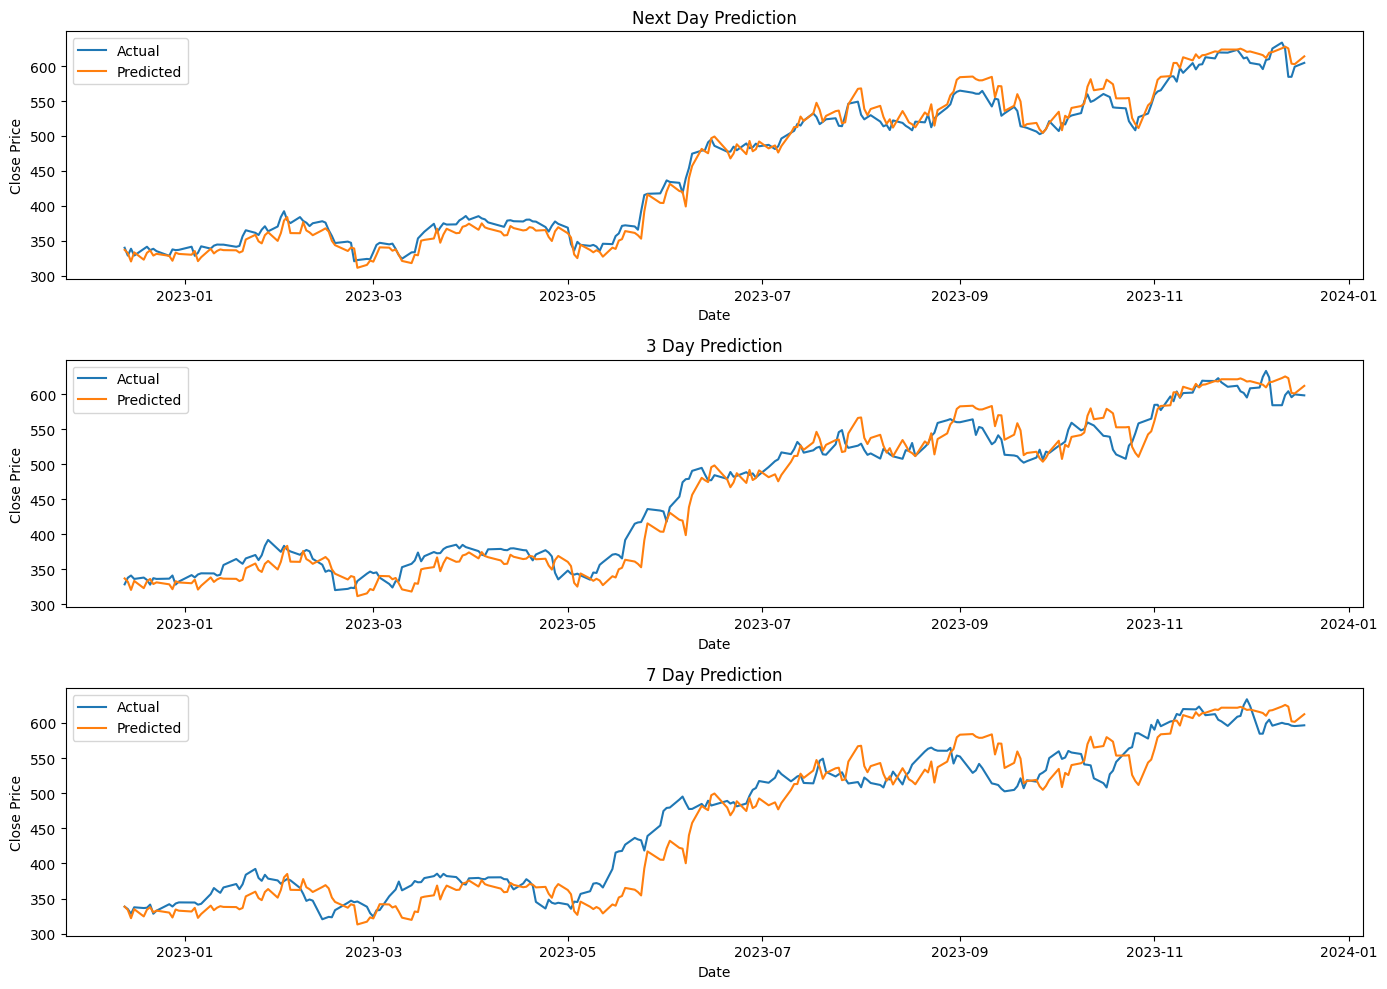

In [103]:
# Make predictions
predictions = model.predict([x50, x200, xvol, xticker])

# Extract predictions for each time horizon
next_day_pred = predictions[:, 0]
three_days_pred = predictions[:, 1]
next_week_pred = predictions[:, 2]

# Extract actual values for each time horizon
next_day_actual = yvals[:, 0]
three_days_actual = yvals[:, 1]
next_week_actual = yvals[:, 2]

# Plot the results
plt.figure(figsize=(14, 10))

# Next day predictions
plt.subplot(3, 1, 1)
plt.plot(dates, next_day_actual, label='Actual')
plt.plot(dates, next_day_pred, label='Predicted')
plt.title('Next Day Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Three day predictions
plt.subplot(3, 1, 2)
plt.plot(dates, three_days_actual, label='Actual')
plt.plot(dates, three_days_pred, label='Predicted')
plt.title('3 Day Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Next week predictions
plt.subplot(3, 1, 3)
plt.plot(dates, next_week_actual, label='Actual')
plt.plot(dates, next_week_pred, label='Predicted')
plt.title('7 Day Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Final Portfolio Value: $977.50
Return on Investment: -2.25%


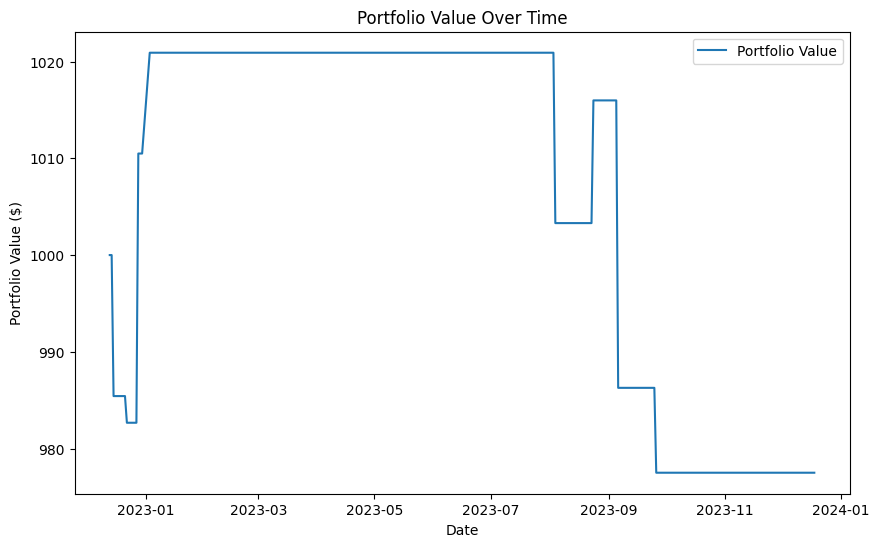

In [104]:
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

TICKER = 'AAPL'

# Load the data
data = yf.download(TICKER, start="2022-03-01", end="2024-01-01")
data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close'])
data.insert(0, 'Ticker', TICKER, True)

data['Date'] = data.index
data['index'] = range(len(data))
data.set_index('index', inplace=True)

# Preprocess the data
dates = []
x50 = []
x200 = []
xvol = []
xticker = []

for i in range(50*4, len(data) - 7):
    dates.append(data['Date'].values[i-1])
    x50.append(data['Close'].values[i-50:i])
    x200.append(data['Close'].values[i-200:i])
    xvol.append(data['Volume'].values[i-50:i])
    ticker = TICKERS_ONEHOT[TOP_25_STOCKS.index(TICKER)]
    xticker.append(ticker)

x50 = np.array(x50)
x200 = np.array(x200)
xvol = np.array(xvol)
xticker = np.array(xticker)


# Make predictions
predictions = model.predict([x50, x200, xvol, xticker])

# Extract predictions for next day
next_day_pred = predictions[:, 0]

# Extract actual close prices
actual_close = data['Close'].values[50*4:]

# Initialize variables for simulation
initial_capital = 1000
cash = initial_capital
position = 0  # Number of shares held
portfolio_value = []

for i in range(len(next_day_pred)):
    current_price = actual_close[i]
    predicted_next_price = next_day_pred[i]
    
    # Buy if the predicted next day price is higher than the current price
    if predicted_next_price > current_price:
        if cash > 0:  # Buy only if we have cash
            position = cash / current_price  # Buy as many shares as we can
            cash = 0
    # Sell if the predicted next day price is lower than the current price
    elif predicted_next_price < current_price:
        if position > 0:  # Sell only if we have shares
            cash = position * current_price  # Sell all shares
            position = 0
    
    # Calculate portfolio value
    portfolio_value.append(cash + position * current_price)

# Calculate final portfolio value
final_portfolio_value = cash + position * actual_close[-1]

# Calculate ROI
roi = (final_portfolio_value - initial_capital) / initial_capital * 100
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Return on Investment: {roi:.2f}%")

# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(dates, portfolio_value, label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

In [105]:
data = yf.download(TICKER, start="2022-03-01", end="2024-07-22")


x50 = [data['Close'].values[len(data)-50:]]
x200 = [data['Close'].values[len(data)-200:]]
xvol = [data['Volume'].values[len(data)-50:]]
xticker = [TICKERS_ONEHOT[TOP_25_STOCKS.index(TICKER)]]

x50 = np.array(x50)
x200 = np.array(x200)
xvol = np.array(xvol)
xticker = np.array(xticker)

prediction = model.predict([x50, x200, xvol, xticker])
print(data['Close'].values[-1])
print(prediction)

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
224.30999755859375
[[222.18077 223.01569 223.35847]]


In [106]:
model.save('models.keras')